In [3]:
import tensorflow as tf
import keras

print(tf.__version__)
keras.backend.clear_session()
print(tf.config.list_physical_devices("GPU"))

tf.random.set_seed(42)

2.18.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import numpy as np
import pandas as pd

In [5]:
from pathlib import Path

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

In [ ]:
import pickle

file_path = "/home/t.afanasyeva/deep_learning_anaemias/output/250208_cytpix/250208_EfficientNetB0v2_score.pkl"

with open(file_path, "rb") as file:
    data = pickle.load(file)

print(data)

{'EfficientNetB0': {'scores': {'test_balanced_accuracy': np.float64(0.91049625184556), 'test_f1_weighted': 0.9098452707440259, 'test_precision_weighted': 0.909849317202477, 'test_recall_weighted': 0.91}}}


In [ ]:
file_path = "/home/t.afanasyeva/deep_learning_anaemias/output/250208_cytpix/250208_EfficientNetB0v2_history.pkl"

with open(file_path, "rb") as file:
    data = pickle.load(file)

print(data)

{'EfficientNetB0': {'history': {'accuracy': [0.7716666460037231, 0.8768333196640015, 0.8948333263397217, 0.9098333120346069, 0.918916642665863, 0.9277499914169312, 0.9393333196640015, 0.9438333511352539, 0.9566666483879089, 0.9617499709129333, 0.9653333425521851, 0.9703333377838135, 0.9725833535194397, 0.9791666865348816, 0.9775833487510681, 0.9857500195503235, 0.9850833415985107, 0.9854166507720947, 0.9904999732971191, 0.9913333058357239, 0.9934999942779541, 0.9960833191871643, 0.9973333477973938, 0.9977499842643738, 0.9984166622161865, 0.9990833401679993, 0.9994999766349792, 0.9994166493415833, 0.9995833039283752, 0.9994166493415833, 0.9994166493415833, 0.9995833039283752, 0.9994166493415833, 0.9994999766349792, 0.999750018119812, 0.9994166493415833, 0.9994999766349792, 0.999833345413208, 0.9994166493415833, 0.999750018119812, 0.999750018119812, 0.999750018119812, 0.999916672706604, 0.999666690826416, 0.999750018119812, 0.999750018119812, 0.999750018119812], 'loss': [0.61769622564315

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_history(model_name, history, metrics):
    sns.lineplot(data=history[metrics[0]], label=metrics[0])
    sns.lineplot(data=history[metrics[1]], label=metrics[1])
    plt.xlabel("epochs")
    plt.ylabel("metric")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    title = f"{model_name} {'Accuracy' if metrics[0] == 'accuracy' else 'Loss'}"
    plt.title(title)
    plt.savefig(
        f"/home/t.afanasyeva/deep_learning_anaemias/output/{model_name}_{metrics}_history.png",
        bbox_inches="tight",
    )
    plt.show()
    plt.close()

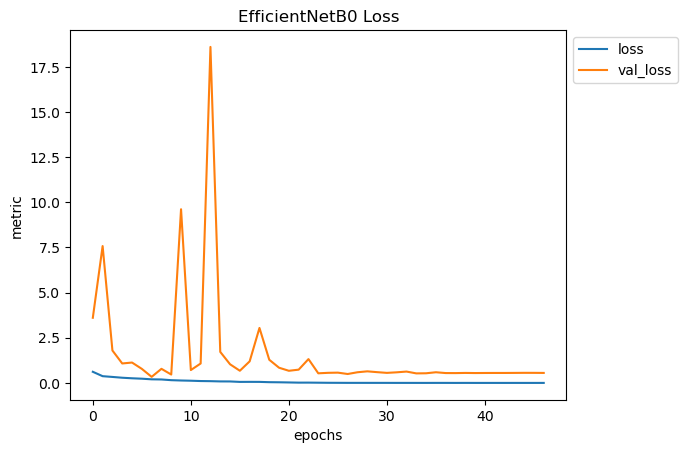

In [ ]:
model_name = "EfficientNetB0"
history = data[model_name]["history"]
metrics = ["loss", "val_loss"]

plot_history(model_name, history, metrics)

In [1]:
from tensorflow.keras.models import load_model

model_path = "/home/t.afanasyeva/deep_learning_anaemias/output/250208_cytpix/250208_EfficientNetB0_v2.keras"
model = load_model(model_path)

2025-02-10 12:03:58.667227: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-10 12:03:59.809185: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739185439.966583 3106552 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739185440.007115 3106552 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-10 12:04:00.362741: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
path_in = Path.cwd().parent / "resources/cytpix/augmented"

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 224

train_ds, test_ds = keras.utils.image_dataset_from_directory(
    path_in,
    labels="inferred",
    label_mode="categorical",
    class_names=[
        "discocyte",
        "granular",
        "holly_leaf",
        "sickle",
        "echinocyte",
    ],
    color_mode="rgb",
    batch_size=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=93,
    validation_split=0.2,
    subset="both",
    data_format="channels_last",
    verbose=True,
)
class_names = test_ds.class_names

Found 15000 files belonging to 5 classes.
Using 12000 files for training.
Using 3000 files for validation.


In [16]:
from sklearn.metrics import (
    classification_report,
)
from keras.applications.efficientnet import (
    preprocess_input as efficientnetb0_preprocess_input,
)

In [17]:
test_ds = (
    test_ds.map(
        lambda x, y: (efficientnetb0_preprocess_input(x), y),
        num_parallel_calls=AUTOTUNE,
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [ ]:
from sklearn.metrics import classification_report

y_test = tf.concat([y for _, y in test_ds], axis=0)
y_test = np.argmax(y_test, axis=1)
y_pred = model.predict(test_ds)
y_pred = y_pred.argmax(axis=1)

report = classification_report(y_test, y_pred, target_names=class_names)
print(report)

2025-02-10 12:09:00.046563: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
I0000 00:00:1739185741.780949 3106855 service.cc:148] XLA service 0x7f457c002770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739185741.780992 3106855 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-02-10 12:09:01.881329: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739185742.457332 3106855 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/94 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step

I0000 00:00:1739185747.473964 3106855 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step
              precision    recall  f1-score   support

   discocyte       0.97      0.94      0.95       554
    granular       0.02      0.02      0.02       624
  holly_leaf       0.01      0.01      0.01       601
      sickle       0.00      0.00      0.00       597
  echinocyte       0.00      0.00      0.00       624

    accuracy                           0.18      3000
   macro avg       0.20      0.19      0.20      3000
weighted avg       0.19      0.18      0.18      3000



In [ ]:
import csv

report_path = "/home/t.afanasyeva/deep_learning_anaemias/output/250208_cytpix/classification_report.csv"

# Split the report into lines
report_lines = report.split("\n")

# Extract the header and data lines
header = report_lines[0].split()
data_lines = [line.split() for line in report_lines[2:-3]]

# Write to CSV
with open(report_path, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(data_lines)

print(f"Classification report exported to {report_path}")

Classification report exported to /home/t.afanasyeva/deep_learning_anaemias/output/250208_cytpix/classification_report.csv
